The main objective of this dataset is to predict car prices,

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Download Dataset

In [35]:
# !kaggle datasets download ahmedwaelnasef/cars-dataset

In [36]:
# import zipfile

# with zipfile.ZipFile('cars-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('cars-dataset')

## Import Dataset

In [37]:
car_df = pd.read_csv('cars-dataset/cars.csv')

In [38]:
car_df.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


In [39]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [40]:
car_df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In [41]:
print(car_df.columns)

Index(['car name', 'price', 'engine_capacity', 'cylinder', 'horse_power',
       'top_speed', 'seats', 'brand', 'country'],
      dtype='object')


In [42]:
currencies=set()

for price in car_df['price']:
    if not any(chr.isdigit() for chr in price):
        car_df['price'] = car_df['price'].replace(price, -1)
    else:
            currencies.add(price.split(' ')[0])



In [43]:
currencies

{'AED', 'BHD', 'EGP', 'F8', 'KWD', 'OMR', 'QAR', 'SAR'}

In [44]:
exchange_rates = {
    'AED': 3.6725,  # 1 USD = 3.6725 AED
    'BHD': 0.377,   # 1 USD = 0.377 BHD
    'EGP': 30.22,   # 1 USD = 30.22 EGP
    'KWD': 0.308,   # 1 USD = 0.308 KWD
    'OMR': 0.384,   # 1 USD = 0.384 OMR
    'QAR': 3.64,    # 1 USD = 3.64 QAR
    'SAR': 3.75     # 1 USD = 3.75 SAR
}


In [45]:
converted_prices = []

for price in car_df['price']:
    if price == -1:
        converted_prices.append(np.nan)
    else:
        currency = price.split(' ')[0]
        try:
            price_value = float(price.split(' ')[1].replace(',', '')) # remove the comma in the number
            converted_price = price_value / exchange_rates[currency]
            #add only 3 digits after the decimal point
            converted_price = round(converted_price, 3)
            converted_prices.append(converted_price)
        except (ValueError, IndexError):
            converted_prices.append(np.nan)

car_df['price_usd'] = converted_prices
car_df.drop('price', axis=1, inplace=True)

In [46]:
car_df

,car name,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
0,Fiat 500e 2021 La Prima,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa,NaN
1,Peugeot Traveller 2021 L3 VIP,2.0,4,180,8 Seater,8.8,peugeot,ksa,37486.667
2,Suzuki Jimny 2021 1.5L Automatic,1.5,4,102,145,4 Seater,suzuki,ksa,26342.667
3,Ford Bronco 2021 2.3T Big Bend,2.3,4,420,4 Seater,7.5,ford,ksa,52800.000
4,Honda HR-V 2021 1.8 i-VTEC LX,1.8,4,140,190,5 Seater,honda,ksa,NaN
...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,6.8,8,505,296,5 Seater,bentley,uae,NaN
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,4.0,8,25,800,Automatic,ferrari,uae,480898.570
6305,Rolls Royce Wraith 2021 6.6L Base,6.6,12,624,250,4 Seater,rolls-royce,uae,381211.709
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,6.5,NaN,740,350,2 Seater,lamborghini,uae,449285.228


In [47]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         6308 non-null   object 
 1   engine_capacity  6308 non-null   object 
 2   cylinder         5684 non-null   object 
 3   horse_power      6308 non-null   object 
 4   top_speed        6308 non-null   object 
 5   seats            6308 non-null   object 
 6   brand            6308 non-null   object 
 7   country          6308 non-null   object 
 8   price_usd        4979 non-null   float64
dtypes: float64(1), object(8)
memory usage: 443.7+ KB


In [48]:
car_df['price_usd'].describe()

count    4.979000e+03
mean     7.222527e+04
std      1.069692e+05
min      4.765056e+03
25%      2.568890e+04
50%      4.752604e+04
75%      8.385989e+04
max      3.550613e+06
Name: price_usd, dtype: float64

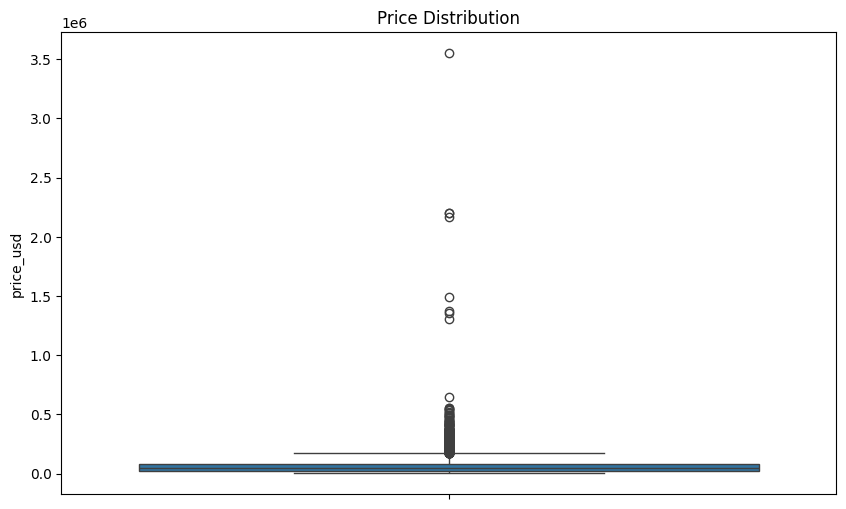

In [49]:
# draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

In [50]:
#handling outliers
# drop any row that has a price greater than 3M USD
car_df = car_df[car_df['price_usd'] < 3000000]


In [51]:
car_df['price_usd'].describe()
# from 4700 to 2.2M USD 

count    4.978000e+03
mean     7.152652e+04
std      9.493792e+04
min      4.765056e+03
25%      2.568176e+04
50%      4.750307e+04
75%      8.374334e+04
max      2.200604e+06
Name: price_usd, dtype: float64

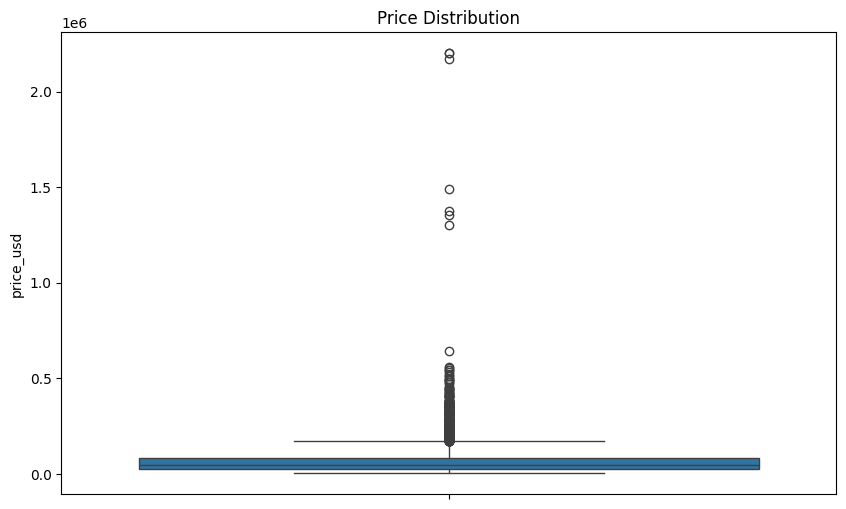

In [52]:
#draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

In [53]:
engine_capacities = []

for val in car_df['engine_capacity']:
    try:
        val = float(val)
        if val <= 0:
            engine_capacities.append(np.nan)
        elif val < 10:
            engine_capacities.append(val * 1000)
        else:
            engine_capacities.append(val)

    except ValueError: # if the value is not a number
        print(val)
        engine_capacities.append(np.nan)

car_df['engine_capacity_edited'] = engine_capacities

car_df.drop('engine_capacity', axis=1, inplace=True)
#


Cylinders


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23212\3974221890.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['engine_capacity_edited'] = engine_capacities
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23212\3974221890.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df.drop('engine_capacity', axis=1, inplace=True)


In [54]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4978 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4978 non-null   object 
 1   cylinder                4447 non-null   object 
 2   horse_power             4978 non-null   object 
 3   top_speed               4978 non-null   object 
 4   seats                   4978 non-null   object 
 5   brand                   4978 non-null   object 
 6   country                 4978 non-null   object 
 7   price_usd               4978 non-null   float64
 8   engine_capacity_edited  4933 non-null   float64
dtypes: float64(2), object(7)
memory usage: 388.9+ KB


In [55]:
car_df['engine_capacity_edited'].describe()

count    4933.000000
mean     2810.422258
std      1281.450994
min       140.000000
25%      2000.000000
50%      2500.000000
75%      3500.000000
max      6800.000000
Name: engine_capacity_edited, dtype: float64

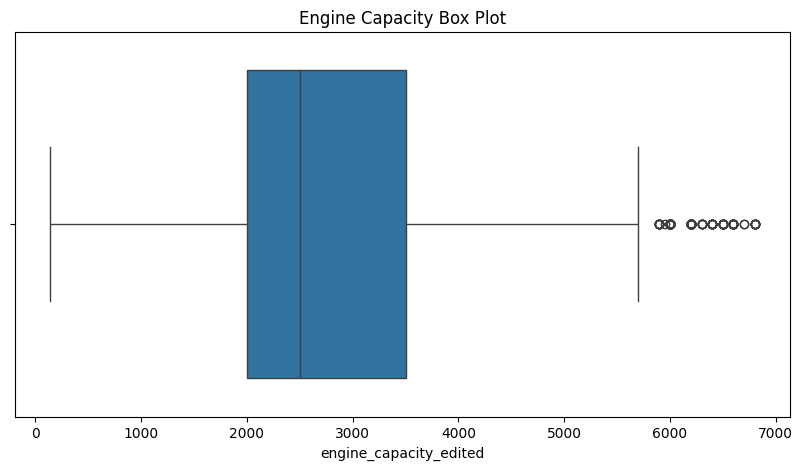

In [56]:

# draw box plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()

    

In [57]:
# the engine capacity is in cubic centimeters can be from 600 to 8000 cm^3

car_df = car_df[(car_df['engine_capacity_edited'] >= 600) & (car_df['engine_capacity_edited'] <= 8000)]


In [58]:

car_df['engine_capacity_edited'].describe()

count    4932.000000
mean     2810.963706
std      1281.016466
min       999.000000
25%      2000.000000
50%      2500.000000
75%      3500.000000
max      6800.000000
Name: engine_capacity_edited, dtype: float64

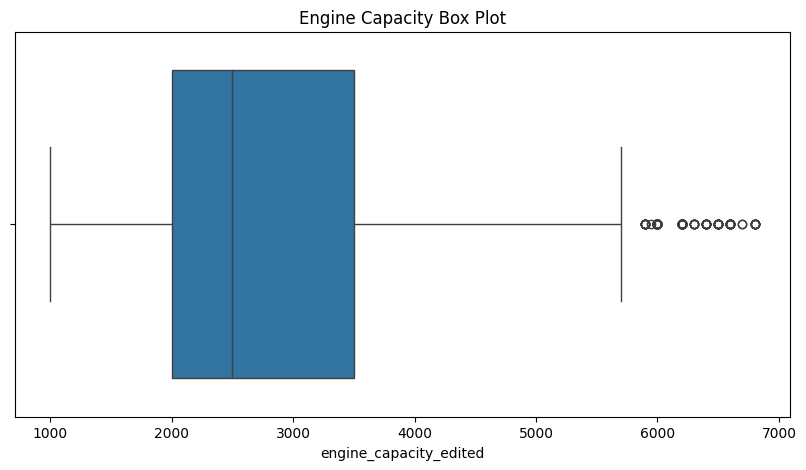

In [59]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()

In [60]:
car_df.head()

,car name,cylinder,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited
1,Peugeot Traveller 2021 L3 VIP,4,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0
2,Suzuki Jimny 2021 1.5L Automatic,4,102,145,4 Seater,suzuki,ksa,26342.667,1500.0
3,Ford Bronco 2021 2.3T Big Bend,4,420,4 Seater,7.5,ford,ksa,52800.000,2300.0
5,Honda HR-V 2021 1.8 i-VTEC EX,4,140,190,5 Seater,honda,ksa,25422.667,1800.0
6,Peugeot Expert 2021 Van L3 A/T,4,120,170,N A,peugeot,ksa,22092.000,2000.0


In [61]:
cylinders = []
c = set()
for cylinder in car_df['cylinder']:
    try:
        cylinder=int(cylinder)

        if cylinder <= 0:
            cylinders.append(np.nan)
        else:
            cylinders.append(cylinder)
    except ValueError:
        cylinders.append(np.nan)

car_df['cylinder_edited'] = cylinders
# make int type
car_df.drop('cylinder', axis=1, inplace=True)

In [62]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4932 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4932 non-null   object 
 1   horse_power             4932 non-null   object 
 2   top_speed               4932 non-null   object 
 3   seats                   4932 non-null   object 
 4   brand                   4932 non-null   object 
 5   country                 4932 non-null   object 
 6   price_usd               4932 non-null   float64
 7   engine_capacity_edited  4932 non-null   float64
 8   cylinder_edited         4401 non-null   float64
dtypes: float64(3), object(6)
memory usage: 385.3+ KB


In [63]:

car_df['cylinder_edited'].describe()

count    4401.000000
mean        5.312429
std         1.900084
min         3.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        12.000000
Name: cylinder_edited, dtype: float64

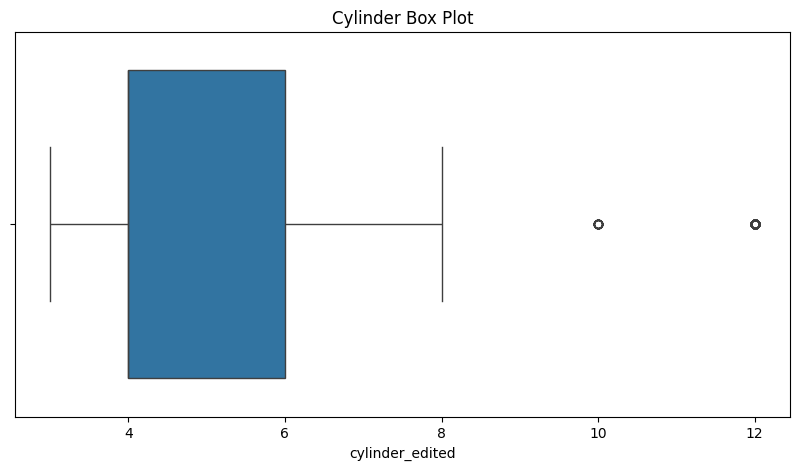

In [64]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['cylinder_edited'])
plt.title('Cylinder Box Plot')
plt.show()

In [65]:
# set of cylinder values
car_df['cylinder_edited'].unique()
#accepted

array([ 4.,  6., 12.,  8., nan,  3.,  5., 10.])

In [66]:
car_df.head()

,car name,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited
1,Peugeot Traveller 2021 L3 VIP,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0
2,Suzuki Jimny 2021 1.5L Automatic,102,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,420,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0
5,Honda HR-V 2021 1.8 i-VTEC EX,140,190,5 Seater,honda,ksa,25422.667,1800.0,4.0
6,Peugeot Expert 2021 Van L3 A/T,120,170,N A,peugeot,ksa,22092.000,2000.0,4.0


In [67]:
hourses = []

for horse in car_df['horse_power']:
    try:
        horse = int(horse)
        if horse <= 0:
            hourses.append(np.nan)
        else:
            hourses.append(horse)
    except ValueError:
        hourses.append(np.nan)

car_df['horse_power_edited'] = hourses
car_df.drop('horse_power', axis=1, inplace=True)

In [68]:
car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4932 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4932 non-null   object 
 1   top_speed               4932 non-null   object 
 2   seats                   4932 non-null   object 
 3   brand                   4932 non-null   object 
 4   country                 4932 non-null   object 
 5   price_usd               4932 non-null   float64
 6   engine_capacity_edited  4932 non-null   float64
 7   cylinder_edited         4401 non-null   float64
 8   horse_power_edited      4915 non-null   float64
dtypes: float64(4), object(5)
memory usage: 385.3+ KB


In [69]:

car_df['horse_power_edited'].describe()

count    4915.000000
mean      282.584741
std       151.033177
min        25.000000
25%       164.000000
50%       248.000000
75%       363.000000
max       900.000000
Name: horse_power_edited, dtype: float64

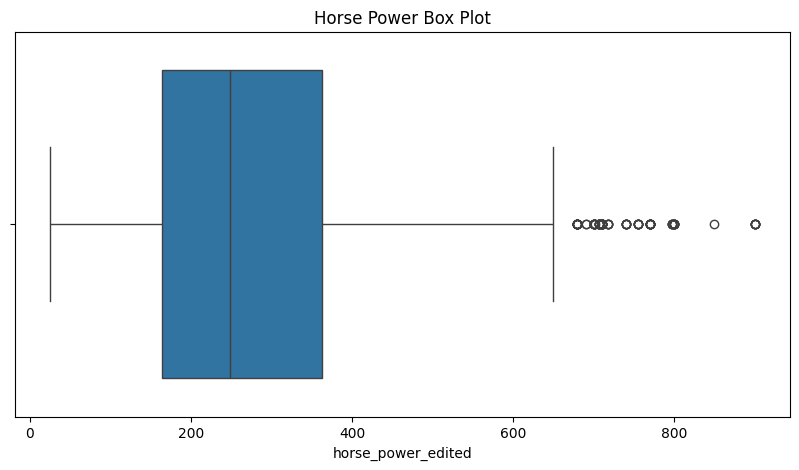

In [70]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

In [71]:
#min horse powwer in 50 and max 2000

car_df = car_df[(car_df['horse_power_edited'] >= 50) & (car_df['horse_power_edited'] <= 2000)]

In [72]:
car_df['horse_power_edited'].describe()

count    4909.000000
mean      282.899572
std       150.856539
min        65.000000
25%       164.000000
50%       248.000000
75%       363.000000
max       900.000000
Name: horse_power_edited, dtype: float64

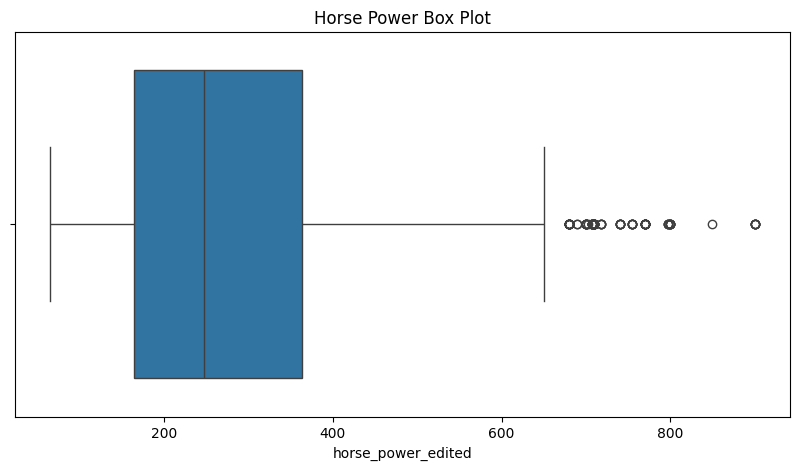

In [73]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

In [74]:

car_df.head()

,car name,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited
1,Peugeot Traveller 2021 L3 VIP,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0
2,Suzuki Jimny 2021 1.5L Automatic,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0
3,Ford Bronco 2021 2.3T Big Bend,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0,420.0
5,Honda HR-V 2021 1.8 i-VTEC EX,190,5 Seater,honda,ksa,25422.667,1800.0,4.0,140.0
6,Peugeot Expert 2021 Van L3 A/T,170,N A,peugeot,ksa,22092.000,2000.0,4.0,120.0


In [75]:
top_speeds = []

for speed in car_df['top_speed']:
    try:
        speed = int(speed)
        if speed <= 0:
            top_speeds.append(np.nan)
        else:
            top_speeds.append(speed)
    except ValueError:
        top_speeds.append(np.nan)

car_df['top_speed_edited'] = top_speeds
car_df.drop('top_speed', axis=1, inplace=True)

In [76]:

car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   seats                   4909 non-null   object 
 2   brand                   4909 non-null   object 
 3   country                 4909 non-null   object 
 4   price_usd               4909 non-null   float64
 5   engine_capacity_edited  4909 non-null   float64
 6   cylinder_edited         4378 non-null   float64
 7   horse_power_edited      4909 non-null   float64
 8   top_speed_edited        4663 non-null   float64
dtypes: float64(5), object(4)
memory usage: 383.5+ KB


In [77]:
car_df['top_speed_edited'].describe()

count    4663.000000
mean      221.069269
std        41.815007
min       120.000000
25%       185.000000
50%       215.000000
75%       250.000000
max       350.000000
Name: top_speed_edited, dtype: float64

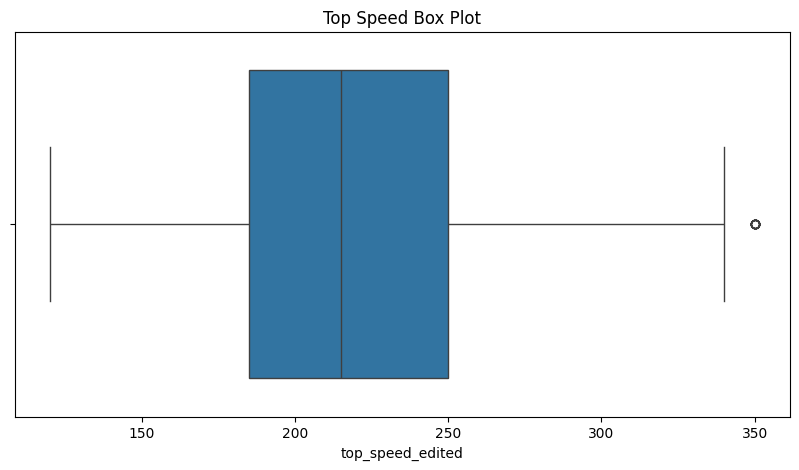

In [78]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['top_speed_edited'])
plt.title('Top Speed Box Plot')
plt.show()

no real outliers in the speed

In [79]:

car_df.head()


,car name,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited
1,Peugeot Traveller 2021 L3 VIP,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN
2,Suzuki Jimny 2021 1.5L Automatic,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,7.5,ford,ksa,52800.000,2300.0,4.0,420.0,NaN
5,Honda HR-V 2021 1.8 i-VTEC EX,5 Seater,honda,ksa,25422.667,1800.0,4.0,140.0,190.0
6,Peugeot Expert 2021 Van L3 A/T,N A,peugeot,ksa,22092.000,2000.0,4.0,120.0,170.0


In [80]:
# the seats are in format # Seater

seats = []

for seat in car_df['seats']:
    try:
        seat = int(seat.split(' ')[0])
        if seat <= 0:
            seats.append(np.nan)
        else:
            seats.append(seat)
    except ValueError:
        seats.append(np.nan)

car_df['seats_edited'] = seats
car_df.drop('seats', axis=1, inplace=True)

In [81]:

car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   brand                   4909 non-null   object 
 2   country                 4909 non-null   object 
 3   price_usd               4909 non-null   float64
 4   engine_capacity_edited  4909 non-null   float64
 5   cylinder_edited         4378 non-null   float64
 6   horse_power_edited      4909 non-null   float64
 7   top_speed_edited        4663 non-null   float64
 8   seats_edited            4612 non-null   float64
dtypes: float64(6), object(3)
memory usage: 383.5+ KB


In [82]:

car_df['seats_edited'].describe()

count    4612.000000
mean        4.939722
std         1.529671
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max        18.000000
Name: seats_edited, dtype: float64

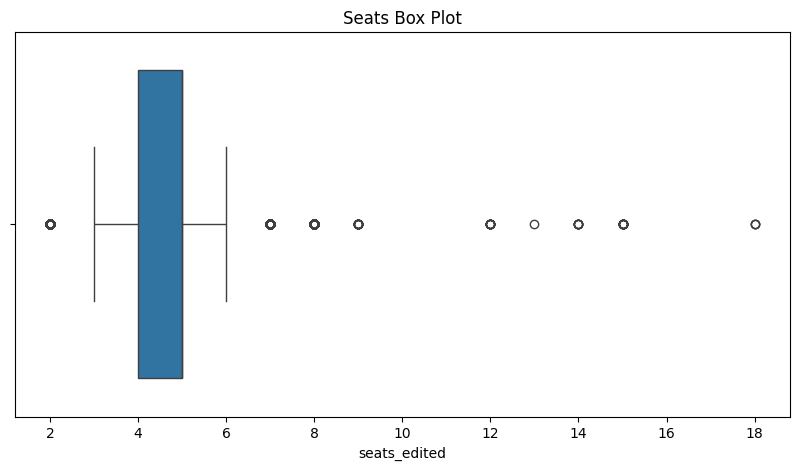

In [83]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['seats_edited'])
plt.title('Seats Box Plot')
plt.show()

In [87]:
#show the car where seat >10
car_df[car_df['seats_edited'] > 10]

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
79,Great Wall Wingle 7 2021 2.0T Double Cabin (4x4),great-wall,ksa,19311.733,2000.0,4.0,315.0,NaN,15.0
85,Great Wall Wingle 7 2021 2.0T Single Cabin (RWD),great-wall,ksa,17165.067,2000.0,4.0,315.0,NaN,15.0
224,Great Wall Wingle 7 2021 2.0T Double Cabin (4x...,great-wall,ksa,19925.067,2000.0,4.0,315.0,NaN,15.0
225,Great Wall Wingle 7 2021 2.4T Double Cabin (4x...,great-wall,ksa,18085.067,2400.0,4.0,220.0,NaN,15.0
229,Great Wall Wingle 7 2021 2.4T Double Cabin (4x...,great-wall,ksa,18698.133,2400.0,4.0,220.0,NaN,15.0
1290,King Long Wide Body Passenger Van 2021 2.7L (1...,kinglong,egypt,6882.859,2693.0,4.0,148.0,156.0,14.0
1294,King Long Wide Body Passenger Van 2021 2.7L (1...,kinglong,egypt,7511.582,2693.0,4.0,148.0,156.0,14.0
1434,Great Wall Wingle 7 2021 2.0T Double Cabin (4x4),great-wall,bahrain,18564.987,2000.0,4.0,315.0,NaN,15.0
1469,Great Wall Wingle 7 2021 2.0T Double Cabin (4x...,great-wall,bahrain,19893.899,2000.0,4.0,315.0,NaN,15.0
1519,Hyundai Creta 2021 1.5L,hyundai,bahrain,17111.406,1500.0,4.0,144.0,NaN,12.0


In [88]:
# show country as a set
car_df['country'].unique()

array(['ksa', 'egypt', 'bahrain', 'qatar', 'oman', 'kuwait', 'uae'],
      dtype=object)

In [89]:
car_df.head()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
1,Peugeot Traveller 2021 L3 VIP,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN,NaN
2,Suzuki Jimny 2021 1.5L Automatic,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,ford,ksa,52800.000,2300.0,4.0,420.0,NaN,NaN
5,Honda HR-V 2021 1.8 i-VTEC EX,honda,ksa,25422.667,1800.0,4.0,140.0,190.0,5.0
6,Peugeot Expert 2021 Van L3 A/T,peugeot,ksa,22092.000,2000.0,4.0,120.0,170.0,NaN


data is cleaned 
remaianing  missing values

In [90]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   brand                   4909 non-null   object 
 2   country                 4909 non-null   object 
 3   price_usd               4909 non-null   float64
 4   engine_capacity_edited  4909 non-null   float64
 5   cylinder_edited         4378 non-null   float64
 6   horse_power_edited      4909 non-null   float64
 7   top_speed_edited        4663 non-null   float64
 8   seats_edited            4612 non-null   float64
dtypes: float64(6), object(3)
memory usage: 383.5+ KB
